In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load a sample dataset (breast cancer dataset)
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(target_names)}")
print(f"Class names: {target_names}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (569, 30)
Number of classes: 2
Class names: ['malignant' 'benign']
Class distribution: [212 357]


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Create a pipeline with preprocessing and KNN classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('knn', KNeighborsClassifier())
])

In [5]:
# 1. Basic KNN with default parameters
print("\n--- Basic KNN with default parameters ---")
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


--- Basic KNN with default parameters ---
Accuracy: 0.9474


In [6]:
# 2. Exploring the impact of different k values
print("\n--- Exploring different k values ---")
k_values = list(range(1, 31, 2))  # Odd numbers from 1 to 30
cv_scores = []

for k in k_values:
    pipeline.set_params(knn__n_neighbors=k)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"k={k}: Cross-validation accuracy = {scores.mean():.4f}")


--- Exploring different k values ---
k=1: Cross-validation accuracy = 0.9429
k=3: Cross-validation accuracy = 0.9604
k=5: Cross-validation accuracy = 0.9604
k=7: Cross-validation accuracy = 0.9560
k=9: Cross-validation accuracy = 0.9516
k=11: Cross-validation accuracy = 0.9560
k=13: Cross-validation accuracy = 0.9582
k=15: Cross-validation accuracy = 0.9538
k=17: Cross-validation accuracy = 0.9560
k=19: Cross-validation accuracy = 0.9560
k=21: Cross-validation accuracy = 0.9538
k=23: Cross-validation accuracy = 0.9538
k=25: Cross-validation accuracy = 0.9538
k=27: Cross-validation accuracy = 0.9516
k=29: Cross-validation accuracy = 0.9516



Best k value from cross-validation: 5


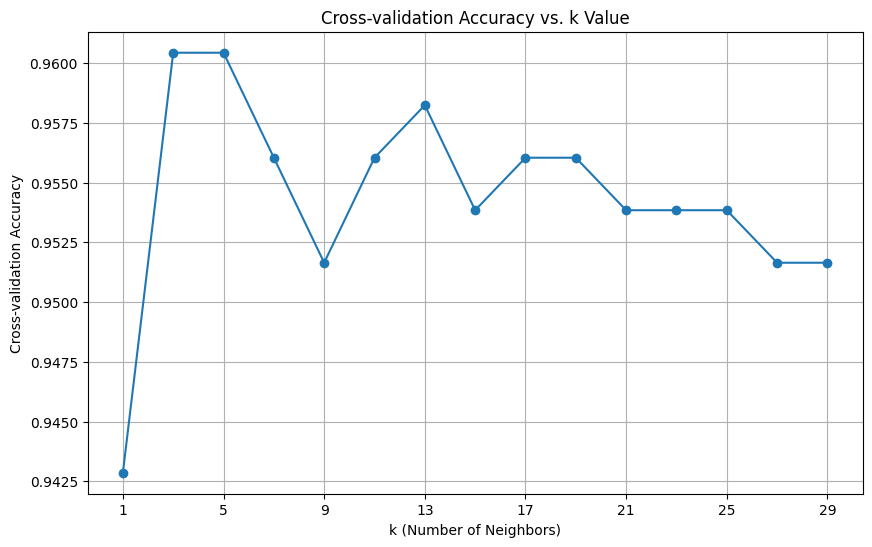

In [7]:
# Plot the CV scores vs k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.title('Cross-validation Accuracy vs. k Value')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-validation Accuracy')
plt.grid(True)
plt.xticks(k_values[::2])  # Show every other k value on x-axis
best_k = k_values[np.argmax(cv_scores)]
print(f"\nBest k value from cross-validation: {best_k}")

In [8]:
# 3. Comprehensive GridSearch for hyper-parameter tuning
print("\n--- Comprehensive Grid Search ---")
param_grid = {
    'knn__n_neighbors': list(range(1, 21, 2)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]  # p=1 for manhattan, p=2 for euclidean
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


--- Comprehensive Grid Search ---
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}
Best cross-validation score: 0.9648


In [9]:
# 4. Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Final Evaluation on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


--- Final Evaluation on Test Set ---
Accuracy: 0.9649

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.95      0.95        43
      benign       0.97      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



Text(0.5, -8.939912440392737, 'Predicted label')

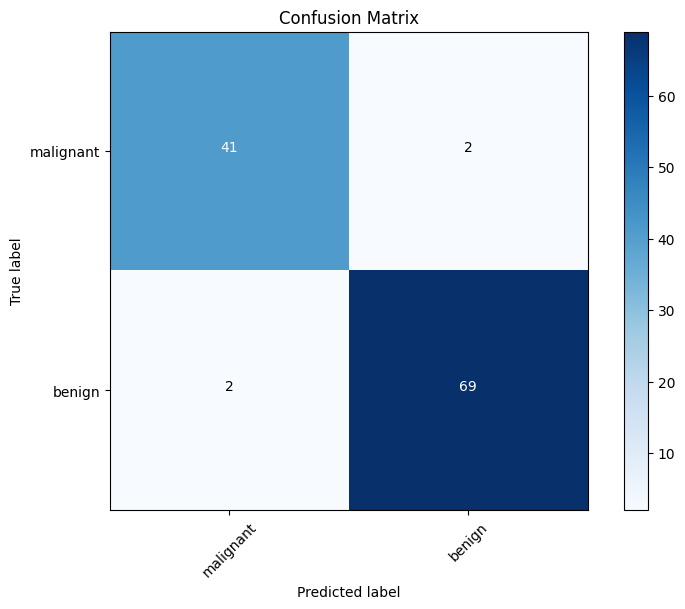

In [10]:
# 5. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [13]:
# 6. Feature importance analysis for KNN
# KNN doesn't have built-in feature importance, so let's use a simple approach
# looking at per-feature accuracy
print("\n--- Feature Importance Analysis ---")

# Get the best k value from grid search
best_k = grid_search.best_params_['knn__n_neighbors']

# Create a scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize list to store feature importances
feature_importance = []

# For each feature, create a model using only that feature
for i in range(X.shape[1]):
    # Extract single feature
    X_train_single = X_train_scaled[:, i:i+1]
    X_test_single = X_test_scaled[:, i:i+1]
    
    # Create and fit KNN model
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train_single, y_train)
    
    # Predict and calculate accuracy
    y_pred = knn.predict(X_test_single)
    acc = accuracy_score(y_test, y_pred)
    feature_importance.append((feature_names[i], acc))

    # Sort features by importance
    feature_importance.sort(key=lambda x: x[1], reverse=True)

# Display top 10 most important features
print("Top 10 most important features:")
for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance:.4f}")


--- Feature Importance Analysis ---
Top 10 most important features:
mean perimeter: 0.9211
mean area: 0.9211
area error: 0.9211
worst perimeter: 0.9211
mean radius: 0.9123
mean concavity: 0.9123
worst radius: 0.9123
worst area: 0.9123
worst concave points: 0.9035
mean concave points: 0.8860



KNN Tuning Complete!


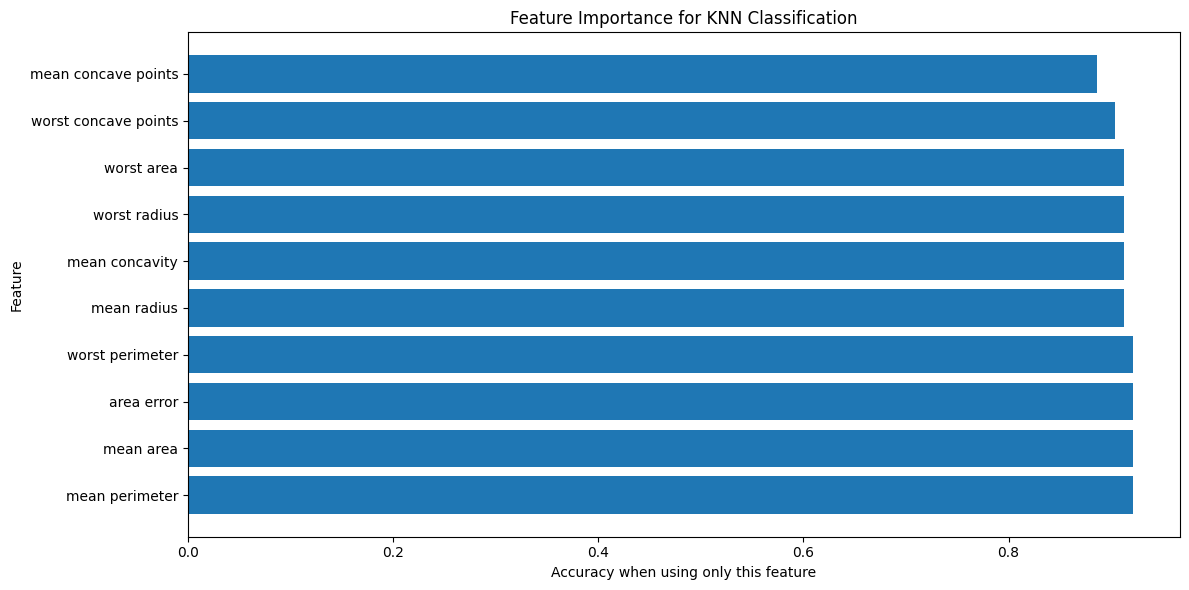

In [14]:
# Plot feature importance
top_features = feature_importance[:10]
plt.figure(figsize=(12, 6))
plt.barh([f[0] for f in top_features], [f[1] for f in top_features])
plt.xlabel('Accuracy when using only this feature')
plt.ylabel('Feature')
plt.title('Feature Importance for KNN Classification')
plt.tight_layout()

print("\nKNN Tuning Complete!")